# Creating a large database

In this section, we will take a look at techniques for creating a database for a large file or number of files.

In [1]:
import pandas as pd
from dfply import *

## Creating a large database with `pandas`

1. Read the first chunk and build cleaning functions.
2. Write the first section to a `db`
3. Use a for loop to <br>
    a. read a chuck<br>
    b. clean the chunk<br>
    c. append the chunk to the `db`<br>

## Example - Creating a Uber database with dateparts

Now we will use `pandas` to read, process and write the Uber data to a database.

## Step 1 - Inspect/clean the first chunk

It is important to automate the type specification and cleaning process. (based on previous work shown above)

#### Imports

In [2]:
from toolz import first
from calendar import day_name
import numpy as np
import pandas as pd
from dfply import *

#### default values

In [3]:
c_size = 10000
new_names = ['date', 'lat', 'lon', 'base']
date_cols = ['date']
weekday_categories = pd.CategoricalDtype(categories=list(day_name),
                                     ordered=True)

#### Create a data frame iterator and pull off the first chunk

In [4]:
c_size = 10000
file = "./data/uber-raw-data-apr14.csv"
df_iter = pd.read_csv(file, 
                      header=0, names=new_names,
                      parse_dates=date_cols,
                      sep=',',
                      engine='python',
                      chunksize=c_size)
first_chunk = next(df_iter)
first_chunk.head()

,date,lat,lon,base
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512


#### Expression for adding various date parts

In [5]:
from functoolz import pipeable
(first_chunk 
 >> mutate(weekday = X.date.dt.weekday_name,
           weekofyear = X.date.dt.weekofyear,
           dayofyear = X.date.dt.dayofyear,
           year = X.date.dt.year,
           month = X.date.dt.month_name(),
           day = X.date.dt.day,
           hour = X.date.dt.hour)
 >> head)

,date,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,Tuesday,14,91,2014,April,1,0
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,Tuesday,14,91,2014,April,1,0
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,Tuesday,14,91,2014,April,1,0
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,Tuesday,14,91,2014,April,1,0
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,Tuesday,14,91,2014,April,1,0


#### Create a functions for adding dateparts

In [6]:
from functoolz import pipeable
add_dateparts = pipeable(lambda df: (df >>
                                     mutate(weekday = X.date.dt.weekday_name,
                                            weekofyear = X.date.dt.weekofyear,
                                            dayofyear = X.date.dt.dayofyear,
                                            year = X.date.dt.year,
                                            month = X.date.dt.month_name(),
                                            day = X.date.dt.day,
                                            hour = X.date.dt.hour)
                                    >> drop(X.date)))
processed_first_chunk = first_chunk >> add_dateparts
processed_first_chunk.head(2)

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour
0,40.7690,-73.9549,B02512,Tuesday,14,91,2014,April,1,0
1,40.7267,-74.0345,B02512,Tuesday,14,91,2014,April,1,0


## Adding a primary key

* **Recall:** Primary keys need to be unique
* We will need to adjust the `id` column
* Make sure first `id` of next chunk is one more than the last

#### A function for adding an `id` column with a given starting value

In [7]:
add_primary_key = pipeable(lambda start, df: (df
                                              >> mutate(id = np.arange(start, start + len(df))
                                              )))

#### Playing around with different chunk indices

In [8]:
from dfply import head
i = 0
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) 
 >> head(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
0,40.769,-73.9549,B02512,Tuesday,14,91,2014,April,1,0,0


In [9]:
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) >> tail(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
9999,40.7656,-73.9697,B02512,Tuesday,15,98,2014,April,8,19,9999


In [10]:
i = 1
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) >> head(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
0,40.769,-73.9549,B02512,Tuesday,14,91,2014,April,1,0,10000


In [11]:
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) >> tail(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
9999,40.7656,-73.9697,B02512,Tuesday,15,98,2014,April,8,19,19999


In [12]:
i = 2
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) >> head(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
0,40.769,-73.9549,B02512,Tuesday,14,91,2014,April,1,0,20000


In [13]:
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) >> tail(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
9999,40.7656,-73.9697,B02512,Tuesday,15,98,2014,April,8,19,29999


#### Compose the helper functions

In [15]:
process_chunk = pipeable(lambda i, df, chunksize=c_size: df >> add_dateparts >> add_primary_key(i*c_size))
first_chunk >> process_chunk(0) >> tail(1)

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
9999,40.7656,-73.9697,B02512,Tuesday,15,98,2014,April,8,19,9999


#### Get the `sqlalchemy` types

In [16]:
from more_sqlalchemy import get_sql_types
i = 0
complete_first_chunk = first_chunk >> process_chunk(i)
sql_types = get_sql_types(complete_first_chunk)
sql_types

{'base': sqlalchemy.sql.sqltypes.String,
 'day': sqlalchemy.sql.sqltypes.Integer,
 'dayofyear': sqlalchemy.sql.sqltypes.Integer,
 'hour': sqlalchemy.sql.sqltypes.Integer,
 'id': sqlalchemy.sql.sqltypes.Integer,
 'lat': sqlalchemy.sql.sqltypes.Float,
 'lon': sqlalchemy.sql.sqltypes.Float,
 'month': sqlalchemy.sql.sqltypes.String,
 'weekday': sqlalchemy.sql.sqltypes.String,
 'weekofyear': sqlalchemy.sql.sqltypes.Integer,
 'year': sqlalchemy.sql.sqltypes.Integer}

## Step 2 - Read, process, and write the first chunk

Use `if_exists='replace'` on this first chuck.

#### Create a new database

In [18]:
!rm ./databases/uber.db

rm: ./databases/uber.db: No such file or directory


In [19]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///databases/uber.db', echo=False)

#### Get the sql schema and create the table

In [20]:
schema = pd.io.sql.get_schema(complete_first_chunk, # dataframe
                              'uber', # name in SQL db
                              keys='id', # primary key
                              con=engine, # connection
                              dtype=sql_types # SQL types
)
print(schema)
engine.execute(schema)


CREATE TABLE uber (
	lat FLOAT, 
	lon FLOAT, 
	base VARCHAR, 
	weekday VARCHAR, 
	weekofyear INTEGER, 
	dayofyear INTEGER, 
	year INTEGER, 
	month VARCHAR, 
	day INTEGER, 
	hour INTEGER, 
	id INTEGER NOT NULL, 
	CONSTRAINT uber_pk PRIMARY KEY (id)
)




## Step 3 - Getting the `df` iterator and read in each processed chunk


In [21]:
c_size = 10000
df_iter = enumerate(pd.read_csv("./data/uber-raw-data-apr14.csv", 
                                header=0, names=new_names, 
                                parse_dates=date_cols,
                                chunksize=c_size,
                                sep=',',
                                engine='python'))

In [22]:
for i, chunk in df_iter:
    processed_chunk = chunk >> process_chunk(i)
    print('writing chunk {0}'.format(i))
    processed_chunk.to_sql('uber', 
                           con=engine, 
                           dtype=sql_types, 
                           index=False,
                           if_exists='append')

writing chunk 0
writing chunk 1
writing chunk 2
writing chunk 3
writing chunk 4
writing chunk 5
writing chunk 6
writing chunk 7
writing chunk 8
writing chunk 9
writing chunk 10
writing chunk 11
writing chunk 12
writing chunk 13
writing chunk 14
writing chunk 15
writing chunk 16
writing chunk 17
writing chunk 18
writing chunk 19
writing chunk 20
writing chunk 21
writing chunk 22
writing chunk 23
writing chunk 24
writing chunk 25
writing chunk 26
writing chunk 27
writing chunk 28
writing chunk 29
writing chunk 30
writing chunk 31
writing chunk 32
writing chunk 33
writing chunk 34
writing chunk 35
writing chunk 36
writing chunk 37
writing chunk 38
writing chunk 39
writing chunk 40
writing chunk 41
writing chunk 42
writing chunk 43
writing chunk 44
writing chunk 45
writing chunk 46
writing chunk 47
writing chunk 48
writing chunk 49
writing chunk 50
writing chunk 51
writing chunk 52
writing chunk 53
writing chunk 54
writing chunk 55
writing chunk 56


## Step 4 - Query the database to test the results


In [23]:
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
engine2 = create_engine('sqlite:///databases/uber.db')
Base = automap_base()
Base.prepare(engine2, reflect=True)
Uber = Base.classes.uber

In [24]:
from sqlalchemy import select, func
stmt = (select([Uber.weekday, 
               func.count(Uber.weekday).label('cnt')])
        .group_by(Uber.weekday))
cnts = pd.read_sql_query(stmt, con=engine2)
cnts

,weekday,cnt
0,Friday,90303
1,Monday,60861
2,Saturday,77218
3,Sunday,51251
4,Thursday,85067
5,Tuesday,91185
6,Wednesday,108631


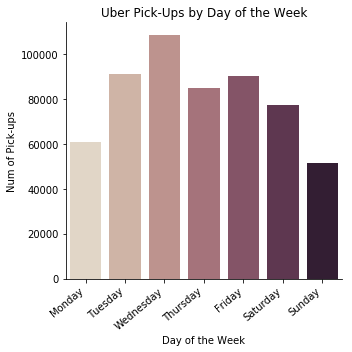

In [25]:
import seaborn as sns
%matplotlib inline
import matplotlib.pylab as plt
ax = (sns
      .catplot(x="weekday", 
               y = 'cnt',
               kind="bar", 
               order=day_name,
               palette="ch:.25", 
               data=cnts))

ax.set_xticklabels(ax.ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title='Uber Pick-Ups by Day of the Week',
       xlabel='Day of the Week', 
       ylabel='Num of Pick-ups')
plt.tight_layout()
plt.show()

## <font color="red"> Exercise 3 </font>

Add the data from the other 5 months to the database.  To do this

1. Use `glob` to get all the file names (filter out april).
2. Write a double `for` loop where
    a. The outer loop is over the file names
    b. The inner loop write each file, in chunks, to the database.
3. You will need keep track of the number of rows added using an accumulator.


Compute and visualize the hourly frequencies for Uber pick-ups for all 6 months, this time with `SQL` queries.

**Hint:** Recall that the primary key column, `id`, needs unique values.  You will need to adjust the `id` column in each chunk using `rows_so_far` (see below).

In [31]:
rows_so_far = cnts.cnt.sum()
rows_so_far

564516

In [41]:
# Your code here
from glob import glob
files = glob('./data/uber/uber-trip-data/*.csv')
files

['./data/uber/uber-trip-data/taxi-zone-lookup.csv',
 './data/uber/uber-trip-data/uber-raw-data-apr14.csv',
 './data/uber/uber-trip-data/uber-raw-data-aug14.csv',
 './data/uber/uber-trip-data/uber-raw-data-sep14.csv',
 './data/uber/uber-trip-data/uber-raw-data-jul14.csv',
 './data/uber/uber-trip-data/uber-raw-data-jun14.csv',
 './data/uber/uber-trip-data/uber-raw-data-may14.csv']

In [42]:
file1 = files[2:]
file1

['./data/uber/uber-trip-data/uber-raw-data-aug14.csv',
 './data/uber/uber-trip-data/uber-raw-data-sep14.csv',
 './data/uber/uber-trip-data/uber-raw-data-jul14.csv',
 './data/uber/uber-trip-data/uber-raw-data-jun14.csv',
 './data/uber/uber-trip-data/uber-raw-data-may14.csv']

In [43]:
import re
from functools import reduce
FILE_NAME_RE = re.compile(r'^\./data/uber/uber-trip-data/uber-raw-data-(may|jun|jul|aug|sep)14\.csv$')
file_name = lambda p: FILE_NAME_RE.findall(p)
file_names = lambda files: [file_name(p) for p in files if file_name(p) != None]
file_names(files)



[[], [], ['aug'], ['sep'], ['jul'], ['jun'], ['may']]

In [44]:
filename = reduce(lambda x,y: x+y,file_names(files))
filename

['aug', 'sep', 'jul', 'jun', 'may']

In [147]:
dfa = {name:pd.read_csv(path) for name, path in zip(filename, file1)}
#[{name:path} for name, path in zip(filename,file)]
dfa['aug'].head(2)

,Date/Time,Lat,Lon,Base
0,8/1/2014 0:03:00,40.7366,-73.9906,B02512
1,8/1/2014 0:09:00,40.7260,-73.9918,B02512


In [26]:
# New names and dtypes
c_size = 10000
new_names = ['date', 'lat', 'lon', 'base']
date_cols = ['date']
weekday_categories = pd.CategoricalDtype(categories=list(day_name),
                                     ordered=True)
hourly = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23)
hour_categories = pd.CategoricalDtype(categories=list(hourly),
                                     ordered=True)

In [118]:
# test 1 file
for file in file1:
        c_size = 10000
        df_iter = pd.read_csv(file, 
                              chunksize=c_size, 
                              sep=',',
                              header=0,
                              names=new_names,
                              parse_dates=date_cols,
                              engine='python')



first_chunk = next(df_iter)
first_chunk.head()


,date,lat,lon,base
0,2014-05-01 00:02:00,40.7521,-73.9914,B02512
1,2014-05-01 00:06:00,40.6965,-73.9715,B02512
2,2014-05-01 00:15:00,40.7464,-73.9838,B02512
3,2014-05-01 00:17:00,40.7463,-74.0011,B02512
4,2014-05-01 00:17:00,40.7594,-73.9734,B02512


In [81]:
# Apply new dtypes on hour col
(first_chunk 
 >> mutate(hour = X.date.dt.hour.astype(hour_categories)) 
 >> sample(5))

,date,lat,lon,base,hour
5311,2014-05-05 10:31:00,40.7326,-74.0038,B02512,10
8250,2014-05-07 17:57:00,40.7432,-73.9933,B02512,17
8036,2014-05-07 15:59:00,40.7612,-73.9627,B02512,15
4532,2014-05-04 14:14:00,40.6450,-73.7819,B02512,14
9420,2014-05-08 14:17:00,40.7600,-73.9878,B02512,14


In [119]:
# Make function for adding dateparts
from functoolz import pipeable
add_dateparts = pipeable(lambda df: (df >>
                                     mutate(weekday = X.date.dt.weekday_name,
                                            weekofyear = X.date.dt.weekofyear,
                                            dayofyear = X.date.dt.dayofyear,
                                            year = X.date.dt.year,
                                            month = X.date.dt.month_name(),
                                            day = X.date.dt.day,
                                            hour = X.date.dt.hour.astype(hour_categories)
                                           )
                                    >> drop(X.date)))
processed_first_chunk = first_chunk >> add_dateparts
processed_first_chunk.head(2)

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour
0,40.7521,-73.9914,B02512,Thursday,18,121,2014,May,1,0
1,40.6965,-73.9715,B02512,Thursday,18,121,2014,May,1,0


In [149]:
# add new primary key from rows_so_far
add_primary_key_1 = pipeable(lambda rows_so_far, df: (df
                                              >> mutate(id = np.arange(rows_so_far, rows_so_far + len(df))
                                              )))

In [162]:
# test it on first chunk
from dfply import head
i = 0
(first_chunk >> add_dateparts 
 >> add_primary_key_1(i*c_size) 
 >> head(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
0,40.7521,-73.9914,B02512,Thursday,18,121,2014,May,1,0,0


#### (first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) >> tail(1))

In [156]:
# wrap it
process_chunk_1 = pipeable(lambda start, df: df >> add_dateparts >> add_primary_key_1(start))
first_chunk >> process_chunk_1(0) >> tail(1)

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
9999,40.7611,-73.9744,B02512,Thursday,19,128,2014,May,8,19,9999


In [157]:
# get sql types
from more_sqlalchemy import get_sql_types
i = 0
complete_first_chunk1 = first_chunk >> process_chunk(i)
sql_types = get_sql_types(complete_first_chunk1)
sql_types

{'base': sqlalchemy.sql.sqltypes.String,
 'day': sqlalchemy.sql.sqltypes.Integer,
 'dayofyear': sqlalchemy.sql.sqltypes.Integer,
 'hour': sqlalchemy.sql.sqltypes.String,
 'id': sqlalchemy.sql.sqltypes.Integer,
 'lat': sqlalchemy.sql.sqltypes.Float,
 'lon': sqlalchemy.sql.sqltypes.Float,
 'month': sqlalchemy.sql.sqltypes.String,
 'weekday': sqlalchemy.sql.sqltypes.String,
 'weekofyear': sqlalchemy.sql.sqltypes.Integer,
 'year': sqlalchemy.sql.sqltypes.Integer}

In [65]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///databases/uber.db', echo=False)

In [66]:
schema = pd.io.sql.get_schema(complete_first_chunk, # dataframe
                              'uber', # name in SQL db
                              keys='id', # primary key
                              con=engine, # connection
                              dtype=sql_types # SQL types
)
print(schema)
engine.execute(schema)


CREATE TABLE uber (
	lat FLOAT, 
	lon FLOAT, 
	base VARCHAR, 
	weekday VARCHAR, 
	weekofyear INTEGER, 
	dayofyear INTEGER, 
	year INTEGER, 
	month VARCHAR, 
	day INTEGER, 
	hour VARCHAR, 
	id INTEGER NOT NULL, 
	CONSTRAINT uber_pk PRIMARY KEY (id)
)




OperationalError: (sqlite3.OperationalError) table uber already exists [SQL: '\nCREATE TABLE uber (\n\tlat FLOAT, \n\tlon FLOAT, \n\tbase VARCHAR, \n\tweekday VARCHAR, \n\tweekofyear INTEGER, \n\tdayofyear INTEGER, \n\tyear INTEGER, \n\tmonth VARCHAR, \n\tday INTEGER, \n\thour VARCHAR, \n\tid INTEGER NOT NULL, \n\tCONSTRAINT uber_pk PRIMARY KEY (id)\n)\n\n']

In [146]:
for file in file1:
    c_size = 10000
    df_iterr = enumerate(pd.read_csv(file, 
                                     chunksize=c_size, 
                                     sep=',',
                                     header=0,
                                     names=new_names,
                                     parse_dates=date_cols,
                                     engine='python'))
    for i,chunk in df_iterr:
       
        processed_chunk = chunk >> process_chunk_1(rows_so_far)
        rows_so_far = rows_so_far + len(chunk)
        print('writing chunk {0},{1}'.format(i,rows_so_far))
        processed_chunk.to_sql('uber', 
                                con=engine, 
                                dtype=sql_types, 
                                index=False,
                                if_exists='append')

writing chunk 0,8524138
writing chunk 1,8534138
writing chunk 2,8544138
writing chunk 3,8554138
writing chunk 4,8564138
writing chunk 5,8574138
writing chunk 6,8584138
writing chunk 7,8594138
writing chunk 8,8604138
writing chunk 9,8614138
writing chunk 10,8624138
writing chunk 11,8634138
writing chunk 12,8644138
writing chunk 13,8654138
writing chunk 14,8664138
writing chunk 15,8674138
writing chunk 16,8684138
writing chunk 17,8694138
writing chunk 18,8704138
writing chunk 19,8714138
writing chunk 20,8724138
writing chunk 21,8734138
writing chunk 22,8744138
writing chunk 23,8754138
writing chunk 24,8764138
writing chunk 25,8774138
writing chunk 26,8784138
writing chunk 27,8794138
writing chunk 28,8804138
writing chunk 29,8814138
writing chunk 30,8824138
writing chunk 31,8834138
writing chunk 32,8844138
writing chunk 33,8854138
writing chunk 34,8864138
writing chunk 35,8874138
writing chunk 36,8884138
writing chunk 37,8894138
writing chunk 38,8904138
writing chunk 39,8914138
writing ch

writing chunk 57,11747670
writing chunk 58,11757670
writing chunk 59,11767670
writing chunk 60,11777670
writing chunk 61,11787670
writing chunk 62,11797670
writing chunk 63,11807670
writing chunk 64,11817670
writing chunk 65,11827670
writing chunk 66,11831514
writing chunk 0,11841514
writing chunk 1,11851514
writing chunk 2,11861514
writing chunk 3,11871514
writing chunk 4,11881514
writing chunk 5,11891514
writing chunk 6,11901514
writing chunk 7,11911514
writing chunk 8,11921514
writing chunk 9,11931514
writing chunk 10,11941514
writing chunk 11,11951514
writing chunk 12,11961514
writing chunk 13,11971514
writing chunk 14,11981514
writing chunk 15,11991514
writing chunk 16,12001514
writing chunk 17,12011514
writing chunk 18,12021514
writing chunk 19,12031514
writing chunk 20,12041514
writing chunk 21,12051514
writing chunk 22,12061514
writing chunk 23,12071514
writing chunk 24,12081514
writing chunk 25,12091514
writing chunk 26,12101514
writing chunk 27,12111514
writing chunk 28,12121

In [68]:
"""for i, chunk in df_iterr:
    processed_chunk = chunk >> process_chunk(i)
    print('writing chunk {0}'.format(i))
    processed_chunk.to_sql('uber', 
                           con=engine, 
                           dtype=sql_types, 
                           index=False,
                           if_exists='append')"""

"for i, chunk in df_iterr:\n    processed_chunk = chunk >> process_chunk(i)\n    print('writing chunk {0}'.format(i))\n    processed_chunk.to_sql('uber', \n                           con=engine, \n                           dtype=sql_types, \n                           index=False,\n                           if_exists='append')"

In [131]:
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
engine2 = create_engine('sqlite:///databases/uber.db')
Base = automap_base()
Base.prepare(engine2, reflect=True)
Uber = Base.classes.uber

In [140]:
from sqlalchemy import select, func
stmt = (select([Uber.hour, 
               func.count(Uber.hour).label('cnt')])
        .group_by(Uber.hour))
hcnts = pd.read_sql_query(stmt, con=engine2)
hcnts

,hour,cnt
0,0,104045
1,1,67372
2,2,45960
3,3,48393
4,4,55338
5,5,84109
6,6,143537
7,7,193491
8,8,190905
9,9,160338


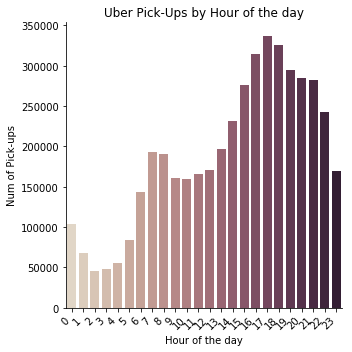

In [144]:
import seaborn as sns
%matplotlib inline
import matplotlib.pylab as plt
ax = (sns
      .catplot(x="hour", 
               y = 'cnt',
               kind="bar", 
               order=hourly,
               palette="ch:.25", 
               data=hcnts))

ax.set_xticklabels(ax.ax.get_xticklabels(), rotation=45, ha="right")
ax.set(title='Uber Pick-Ups by Hour of the day',
       xlabel='Hour of the day', 
       ylabel='Num of Pick-ups')
plt.tight_layout()
plt.show()